# Introduction

## -Project Description

The system used for this project models thrust control on a rocket. This simplified system considers the 1-dimensonal (vertical) motion of the rocket, foregoing control on the 2 horizontal dimensions. In this case, the altitude of the rocket is known and is controlled via a PID algorithm to drive the rocket to maintain a desired height. This control is achieved by changing the velocity of the rocket, which ultimately would be determined by the thrust of the rocket, although velocity is used here for reasons explained in the next section.

Using process controls verbage, the height of the rocket *(What is being controlled)* is the Control Variable (CV), or, as named in this project, the **Process Variable (PV)**, where the rocket speed *(How it is Controlled)* is the **Manipulated Variable (MV)**.

As introduced above, this project achieves control using the velocity of the rocket, rather than using thrust (acceleration). This was chosen as this models a **First Order** system, which is very common throughout the process controls space. A thrust-based approach of this control would result in a **Second Order** system, which has potential to exhibit instability, potentially causing the optimization to fail. 

This project contains 2 discrete parts; Simulation of this system under PID Control, and Optimization of the PID Parameters. 

The simulation of this system inputs the PID tuning parameters, the inital MV and PV, and the setpoint characteristics. These parameters are then used to simulate this process. This simulation return metrics which describe the dynamic behavior of this specific PID tuning. These metrics include the **SAIE**, the **Damping Coefficient**, the **Ultimate Period**, and the **Ultimate Gain**.

The optimization strategy used for this project is **Bayesian Optimization** as implemented by Meta (Facebook) in their Ax platform. This strategy allows for intelligent searching of the parameter space, allowing for fast and efficient optimization. This implementation used the **Sum** of the **Absolute Integral Error** of the system, or **SAIE** as the metric of interest as it is by far the best metric to ensure fast, stable convergence to a new setpoint.


Proper PID tuning is integral to safe, consistent equipment operation needed in industrial production facilities. A properly tuned controller allows operators to reduce material waste while reducing eqipment wear.

## -Current Methods


Currently, there are multiple tuning methods that exist. Classical tuning methods include: Ziegler-Nichols, Cohen & Coon, and Ciancone & Marlin.

**Ziegler-Nichols** Tuning is used for second order processes and completed experimentally using the following process,

1. Turn off  I and D action on PID controller - P-only control

2. Increase P ($K_c$) until sustained oscillations are achieved

3. Determine Ultimate Gain $K_u$, and Ultimate Period $P_u$ 
 
4. Determine controller parameters from Table 8.3

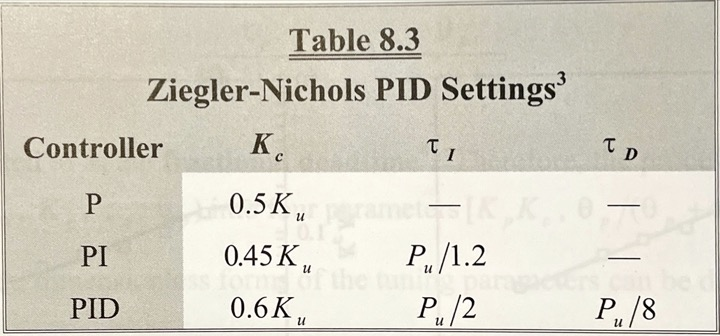

This results in a system which is tuned to result in a decay ratio of 1/4, also known as a Quarter Amplitude damping or QAD response. 

Similarly, **Cohen & Coon's** methodolody results in a QAD response, altough this methodology assumes a First Order Plus Deadtime, or FOPDT model.This model uses data gathered from the system to determine:
> Process Gain, $K_P$
>
> Process Time Constant, $τ_p$
>
> Process Deadtime, $Θ_p$

These parameters are then used to determine the Controller parameters using Table 8.2:

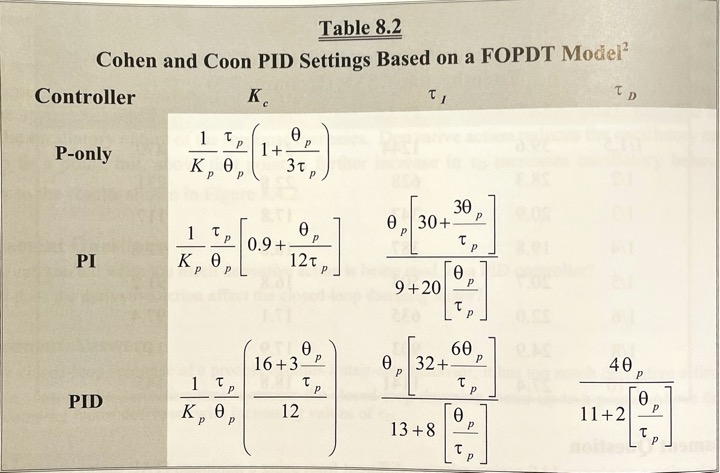

Finally, **Ciancone & Marlin** tuning assumes a FOPDT model, and requires data to determine the $θ_p$ and $τ_p$ of the process. These parameters are then used to determine the fractional deadtime, FD, as defined below.

$$ FD = \frac{τ_p}{θ_p + τ_p} $$

This is then used with the graphs below to determine disturbance rejection parameters (graphs a,b,c), and setpoint tuning parameters (graphs d,e,f).

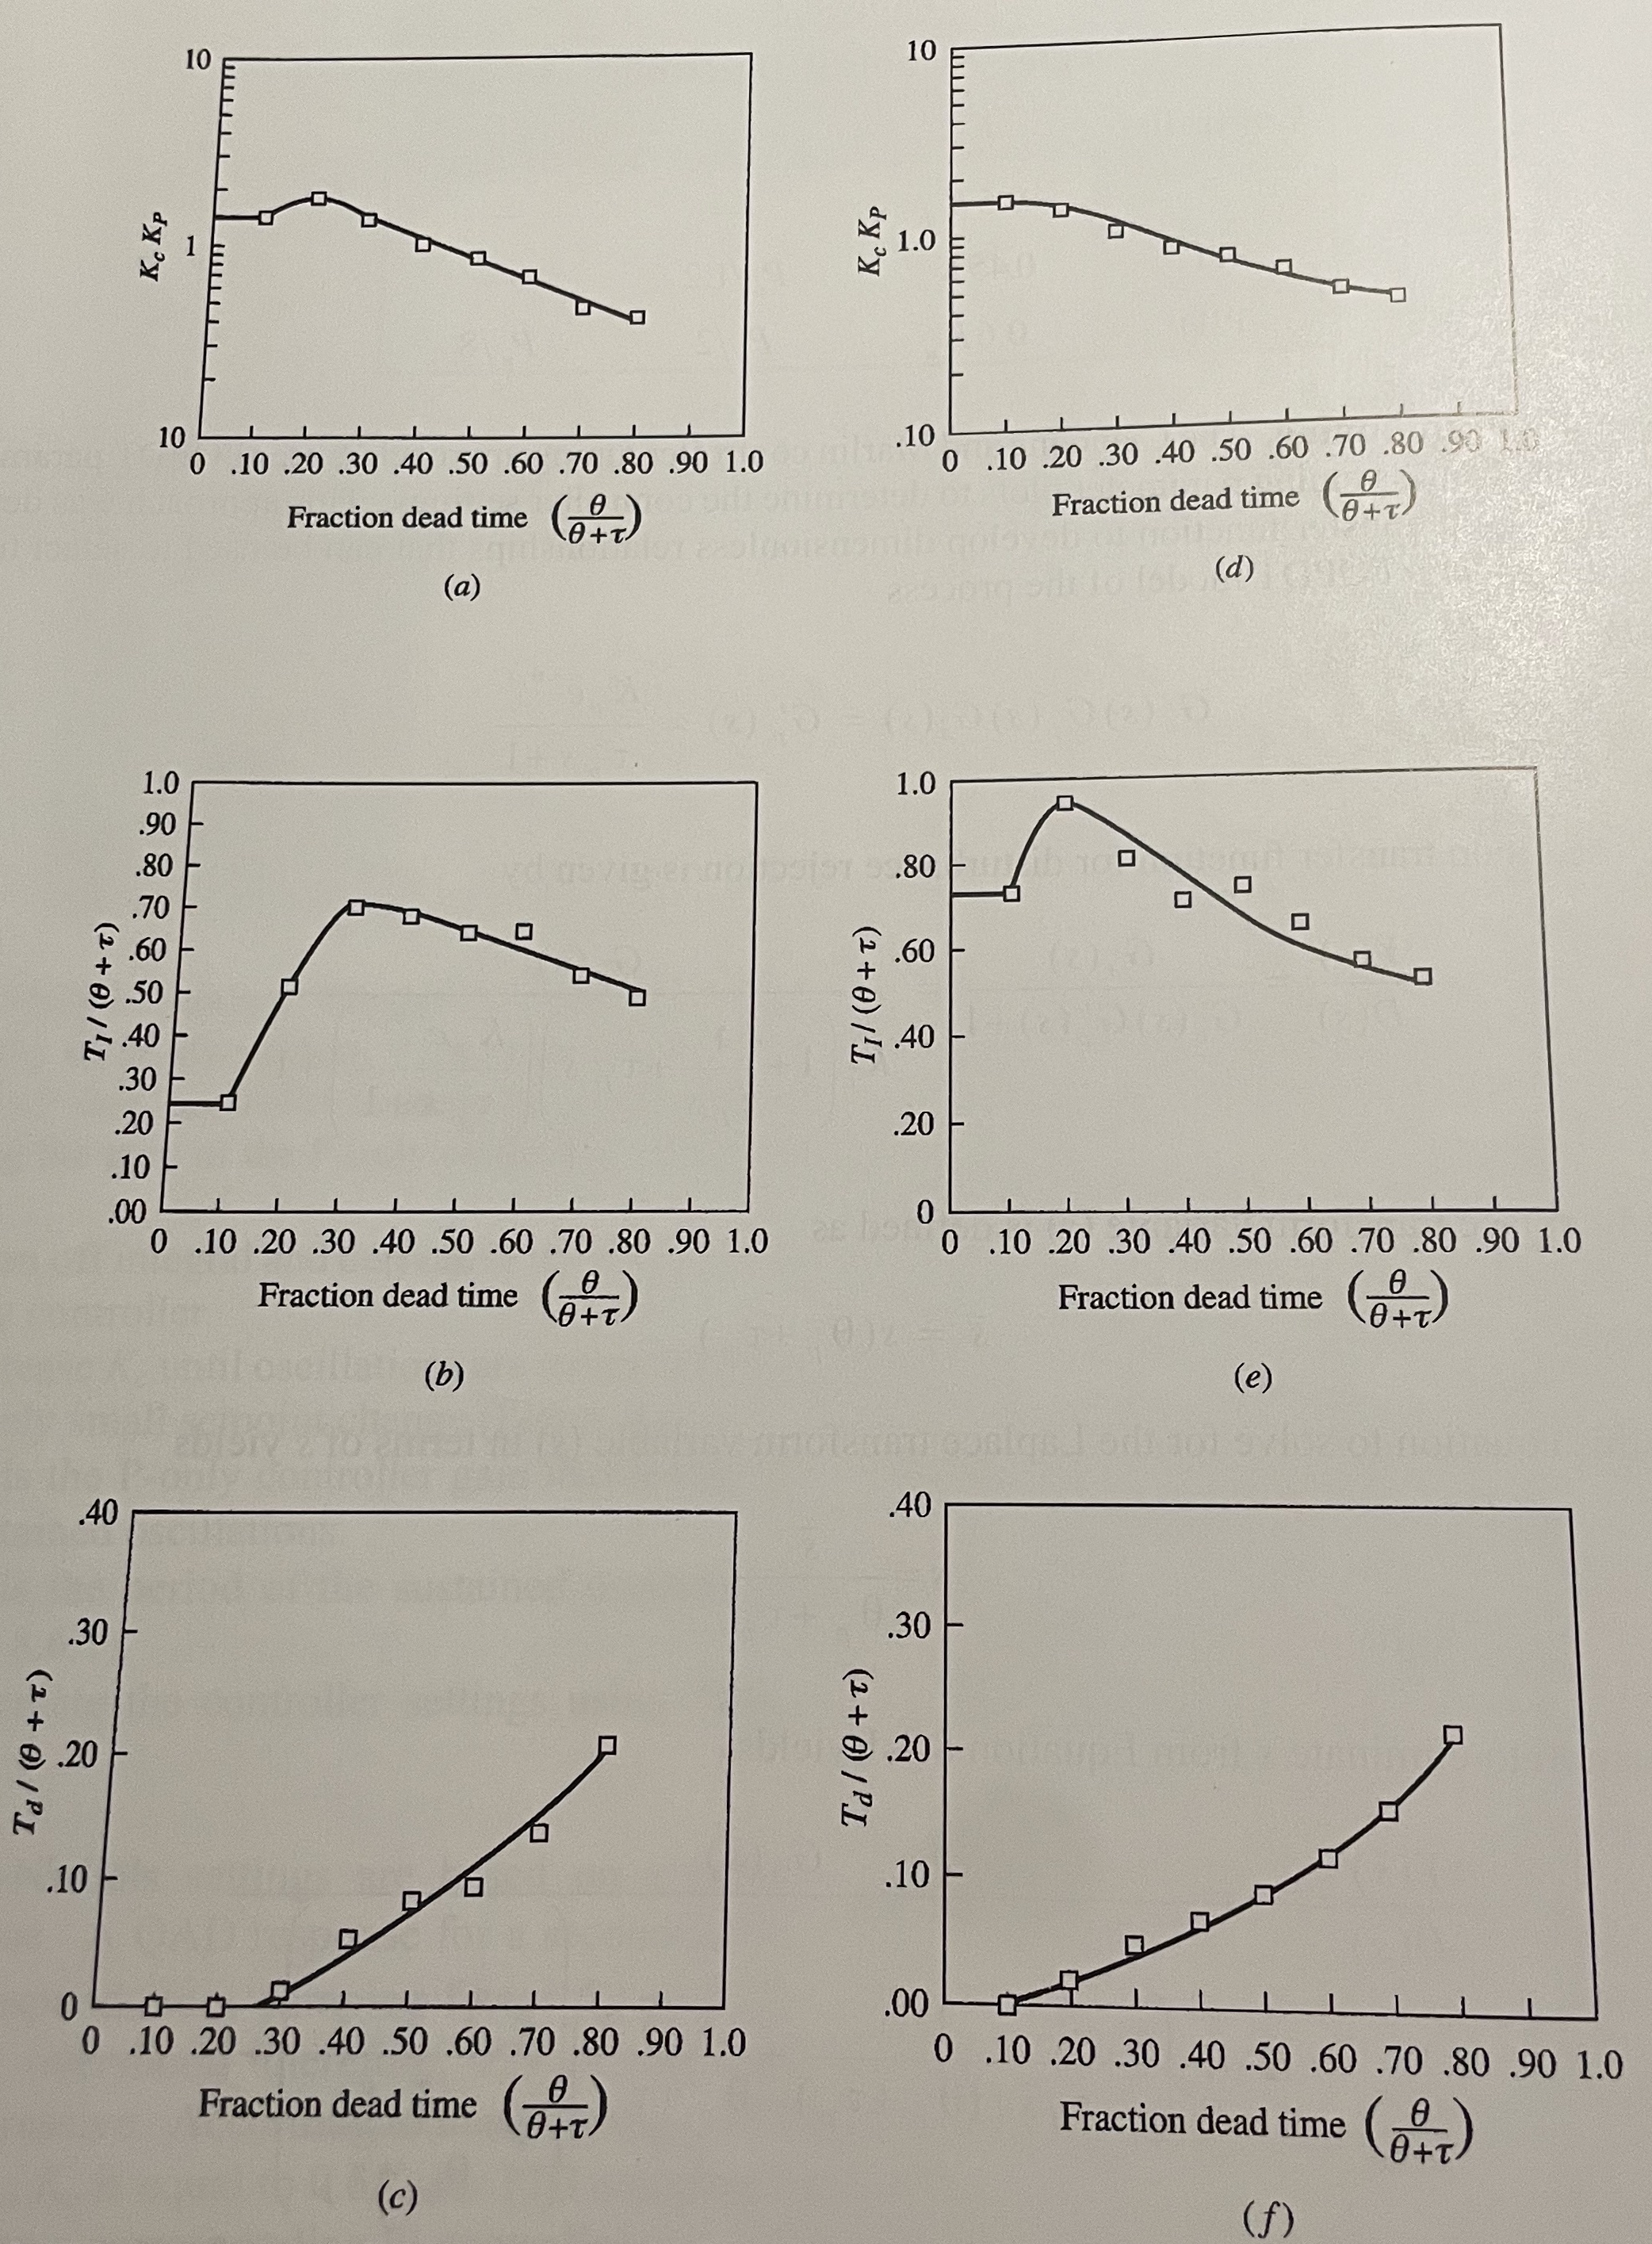

## -Classical Methods Shortcomings

Although these tuning methods work well, each require an engineer to determine the process parameters. Another important consideration is that these tuning methods are empirically derived and do not always result in the best parameters. This serves as a crux as this takes up valuable time an engineer could be using to improve the efficiency of a process. This project serves as a first attempt to solve this issue by providing a framework which can be leveraged to determine the ideal tuning parameters directly from process data. Using the optimization strategy outlined here allows for continual searching of the parameter space to determine the best tuning parameters for this system. 

# Methodology


## -Simulation

### -- Imports

These are library imports which allow the Simulation class to run

In [1]:
import numpy as np                      # provides additional data types and math functionality
import matplotlib.pyplot as plt         # allows data to be plotted
from scipy.integrate import solve_ivp   # allows PV to be solved using an initial value
from scipy.signal import argrelextrema  # allows the return of relative maxima (used to determine metrics)

### -- Simulation Topology

This class contains 3 major purposes:

 - Variable Initialization

 - Simulation Loop

 - Return Functions

**Variable Initialization** occurs in the *__init__()* function which sets seed values for each parameter. The key inputs for this include:
>
> *Input Parameters*
>
> - Tuning parameters - *KP, KI, KD*
>
> - System State - *MV0, PV0*
>
> - Setpoint Change - *t_change, step_to*
>
>
>These parameters are then passed into the *__init__()* function. The *Setpoint()* and *t()* functions are called within this function which initializing the SP and t arrays and returns the number of points and the time step, $dt$.

The **Simulation Loop** is then run using the *cycle()* function. This function iterates over time points as ititialized above. Within each iteration the following steps occur:
>
> *Simulation Loop Steps*
>
> - Save previous data to array
>
> - Controller response
>
> - Process response
>
>
>**Previous Data** such as the component errors, PV, and MV are saved to a numpy arrays, resulting in high resolution data for all the components of the process and controller response. After this is done, new values for each of these parameters are determined using the following two steps.
>
>Within the **Controller()** function, the error, integral error, derivative error, and absolute value integral error are calculated.
>The first three of these are used to calculate the controller response, defined below:
>
> $$ MV(t) = K_p [ e(t) + \frac{\int_0^t e(t)\,\mathrm{d}t}{K_I} + K_D\frac{\mathrm{d} e(t)}{\mathrm{d}t} ] $$
>
>Following this, the **Process()** function is called, this function uses the *solve_ivp* method, as defined by ***Scipy***. This solves the the equation:
> $$ PV(t) = \int_0^{\mathrm{d}t} MV(t)\,\mathrm{d}t $$
> 
> Once complete, these steps are repeated for each entry in the t/SP array. The **cycle()** function then performes it's exit operations. This includes a check to make sure the dimension of the completed arrays match the input array, a conditional statement to graph the system output, and a call to retunr the metrics of this simulation. 

The **Return functions** are the last portion of the Simulation class. These are 3 functions which are used to return attributes of the simulation to the user. These include:
>
> *Return Functions*
> 
> - Metrics
> - Graph
> - Return
>
>
> The **Metrics()** function determines this systems performance using 4 metrics; the SAIE, Damping Coefficient, Ultimate Period, and Ultimate Gain. These metrics are important for evaluating the dynamic behavior of this system. The most significant of these is the SAIE, as this is the metric used in the Ax optimization of the Tuning parameters. The rest of which are used as a point of comparison to classical tuning methods.
>
> The **Graph()** function displays a table of figures of the current simulation, containing graphs of the PV and Setpoint, the MV, the MV components, the Error, and the AIE as functions of time over the course of the simulation.
>
>The **Return()** function returns all the raw data from the simulation. This allows the data to be saved after a simulation but is not used in the parameter optimization.

### --> Simulation Class

In [2]:
class Simulation(object):
# INITILIZATION
    def __init__(self, kp, ki, kd, MV0, PV0,t_change,step_to):   
     ## Bools
        self.Grapher = False
     ## Values
	 # Input Vals
        self.K = kp
        self.I = ki
        self.D = kd
        self.t_c = t_change
     # Current Vals
        # Component Vals
        self.MV = MV0
        self.PV = PV0
        # Error Vals
        self.kp = 0.
        self.ki = 0.
        self.kd = 0.
        self.error = 0.
        self.error_last = 0.
        self.derivative_error = 0.
        self.integral_error = 0.
        self.abs_int_e = 0.

     ## Arrays
        #Input Arrays
        self.TIME_STEP, self.t = self.t()
        self.SP = self.Setpoint(PV0,t_change,step_to)
        #Output Array
        self.data = [[]]
        # Component Arrays
        self.M = np.array([])
        self.P = np.array([])
        # Error arrays
        self.kpe = np.array([])
        self.kde = np.array([])
        self.kie = np.array([])
        self.Error = np.array([])
        self.ABS_IE = np.array([])
        
     ## COUNTERS
        self.sp_i = 0
        self.counter = 0
        #print('SIM_INITILIZED')    
    # Input Arrays
    def Setpoint(self,INITIAL,change_t,step_to):
        SP = np.ones_like(self.t)
        SP = SP*INITIAL
        for i in range(0,len(self.t)):
            if self.t[i] >= change_t:
                SP[i] = step_to
            else:
                continue
        return SP
    def t(self):
        t_Start = 0
        t_End = 10
        self.NUM_PTS = 1000
        t = np.linspace(t_Start,t_End,self.NUM_PTS,retstep=True)
        TIME_STEP = t[-1]
        t = t[0]
        return TIME_STEP,t

# SIMULATION
    def cycle(self):
        for self.sp_i in self.SP:

            #Save previous values to array
            self.kpe = np.append(self.kpe,self.kp)
            self.kde = np.append(self.kde,self.ki)
            self.kie = np.append(self.kie,self.kd)
            self.Error = np.append(self.Error,self.error)
            self.ABS_IE = np.append(self.ABS_IE,self.abs_int_e)
            self.P = np.append(self.P,self.PV)
            self.M = np.append(self.M,self.MV)
            
            #update values
            self.Controller()
            self.Process()

            self.counter += 1
        
        # Exit operations
        if self.counter == self.NUM_PTS:
            print('SCN')
        else:
            print("Simulated for",self.counter,"points instead of",NUM_PTS)
            exit()
        
        if self.Grapher: 
            self.Graph()
            return self.Metrics()
        else:
            return self.Metrics()
    # Process Components
    def Controller(self):
        #update error values
        self.error = self.sp_i - self.PV
        self.integral_error += self.error * self.TIME_STEP
        self.abs_int_e = np.abs((self.error+self.error_last)*self.TIME_STEP*0.5)
        self.derivative_error = (self.error - self.error_last) / self.TIME_STEP
        
        #Term-wise controller response Calculation
        self.set_kp()
        self.set_ki()
        self.set_kd()
        
        #Overall controller response Calulation
        self.MV = self.kp + self.ki + self.kd

        #Save previous
        self.error_last = self.error
    def Process(self):
        t_span = [0, self.TIME_STEP]
        y0 = [self.PV]
        def f(t, y): return self.MV
        res = solve_ivp(f, t_span, y0)
        self.PV = res.y[0, -1]
      		
# RETURN FUNCTIONS
    def Metrics(self):
        t = self.t
        AIE = self.ABS_IE
        maxima = argrelextrema(AIE,np.greater)
        #minima = argrelextrema(AIE,np.less)
        Ku_s = AIE[maxima[0]]
        t_max = t[maxima[0]]

        Pu_s = []
        Damp = []
        for i in range(1,len(t_max)-2):
            Pu_s += [t_max[i+1] - t_max[i]]
            Damp += [Ku_s[i+1]/Ku_s[i]]
        Pu = np.mean(Pu_s)
        DC = np.mean(Damp)
        Ku = Ku_s[0]
        SAIE = np.sum(AIE)
        
        return {'SAIE':SAIE,'DC':DC,'Pu':Pu,'Ku':Ku}
    def Graph(self):
        fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, sharex=True)
        # fig.set(title='UHHHHH')
        ax1.set(ylabel='PV')
        ax1.plot(self.t,self.SP,label='SP')
        ax1.plot(self.t,self.P,label='Process')
        ax1.legend(loc='center right')

        ax2.set(ylabel='MV')
        ax2.plot(self.t,self.M,'tab:purple')

        ax3.set(ylabel='Error')
        ax3.plot(self.t,self.Error,'tab:red')

        ax4.set(ylabel ='MV_cpts')
        ax4.plot(self.t,self.kpe,'tab:orange',label = 'P')
        ax4.plot(self.t,self.kie,'tab:pink',label = 'I')
        ax4.plot(self.t,self.kde,'tab:brown',label = 'D')
        ax4.legend(loc='center right')

        ax5.set(ylabel='AIE')
        ax5.plot(self.t,self.ABS_IE,'tab:green')
        ax5.set(xlabel='time (seconds)')
        plt.show()
    def Return(self):
        self.data = [self.t,self.SP,self.P,self.M,self.Error,self.kpe,self.kie,self.kde,self.ABS_IE]
        # self.data = [self.t,self.ABS_IE]
        return self.data        

# HOUSE KEEPING
    # Setters (W/error removal)
    def set_kp(self):
        self.kp = self.K*self.error
        if self.kp > P_max:		self.kp = P_max
        if self.kp < -P_max:	self.kp = -P_max
    def set_ki(self):
        self.ki = self.K*self.integral_error/self.I
        if self.ki > I_max:		self.ki = I_max
        if self.ki < -I_max:	self.ki = -I_max
    def set_kd(self):
        self.kd = self.K*self.D*self.derivative_error
        if self.kd > D_max: 	self.kd = D_max
        if self.kd < -D_max:	self.kd = -D_max
    # Getters (W/ zero gain removal)
    def get_kpe(self):
        if self.K !=0:	return self.K*self.error
        else:           return self.error
    def get_kde(self):
        if self.I != 0:	return self.I*self.derivative_error
        else:           return self.derivative_error
    def get_kie(self):
        if self.D != 0:	return self.D*self.integral_error
        else:			return self.integral_error

## Controller Action ##
P_max = 10000
I_max = 10000
D_max = 10000

### --> Runner

SCN
{'SAIE': 4.170619886453272, 'DC': 0.3592875658013883, 'Pu': 0.5305305305305306, 'Ku': 0.1342097257974246}


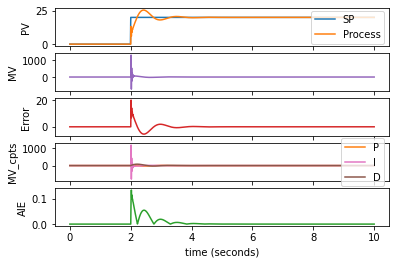

In [3]:
def Run_Sim():
    t_change = 2.
    #PV0(initial process value) also serves as the initial setpoint
    sim = Simulation(kp=5.9385, ki=0.1, kd=0.1, MV0=0., PV0=0., t_change=t_change, step_to=20.)

    metrics = sim.cycle()
    print(metrics)
    data = sim.Return()
    
    sim.Graph()
    

Run_Sim()  

## -Bayesian Optimization

### -- Installing Dependencies

This project requires python packages that are not baked into stock Google Colab, installation of these packages is necessary to run the optimization

In [ ]:
# Needed to run Optimization
! pip install ray[tune]==1.9.0 ax-platform

### -- Imports

In [ ]:
import torch
import os
import ray
import logging
from ray import tune

from ray.tune.suggest.ax import AxSearch
from ax.service.ax_client import AxClient

### -- Optimization Topology

The Optimization strategy used to determine the tuned PID parameters utilizes a number of files to run the optimization, they have been included here in a executable format to be run on Google Colab. These files, arranged from Lowest to Highest level, include:
>
> *Optimization Topology*
> 
> - PID_config
> - ax_config.py
> - PID_t.py
> - opt.py
>
For this optimization, **opt.py** is the highest level file as this is the file that is run to perform the optimization. **Opt.py** takes in specific parameters as defined by ax, the parameter space of which is defined in **PID_config.py**, these parameters are then passed to the Simulation class in **PID_t.py**, which returns the metrics of that trial. This is then sent to tune to be reported. The rest of the optimization is handled by the AxOptimizer class in **ax_config.py**. Each of these files are shown and described below.

### --> PID_config.py

This file contains a dictionary of dictionaries named *config*, the elements of this include
> *config attributes*
>
> - settings 
> - params 
>
>
>*settings* is a Dictionary containing:
>>
>> - "name" 
>> - "num_samples"
>> - "metric" 
>> - "minimize"
>> - "mode"
>>
>>Where,
>>
>> **"name"** is the internal name used to keep results seperate from other ray optimizations
>>
>> **"num_samples"** is number of trials ran to define parameter space
>>
>> **"metric"** is an >internal metric used so Ax/ray understands the metric given
>>
>> **"minimize"** is an internal boolean setting used by ray/Ax to optimize for high(False) or low(True) metric values
>>
>> **"mode"** is an internal string setting used by ray/Ax to optimize for high (max) or low (min) metric values
>>
>*params* is a Dictionary containing:
>>
>> - "name"
>> - "type"
>> - "bounds"
>> - "log_scale"
>> - "value_type"
>>
>>Where,
>>
>> **"name"** is the name of the parameter used in the optimization
>>
>> **"type"** is either "value" or "range": "value" is used for constant parameters, "range" is used for parameters that will be varied/optmimized
>>
>> **"bounds"** are determined if "type" (above) is "range", this will have a list containing the min and max values of the param. if "type" is "value", this will contain the value of the parameter
>>
>> **"log_scale"** is a boolean parameter used by Ax to determine if the parameter space will be on a log scale
>>
>> **"value_type"** is the data type of the value/range of the parameter.
>>

This file serves as a database containing all of the settings and parameters needed to define and perform the optimization. This is then passed to **opt.py** for use by **ax_config**.

In [ ]:
settings = {
    "name": "PID",
    "num_samples": 64, # number of trials
    "metric": "val_score", # don't change this
    "minimize": True, # ""
    "mode": "min", # ""
}

params = [
    {
        "name": "Kp",
        "type": "range",
        "bounds": [1E-2,100],
        "log_scale": True,
        "value_type": "float",
    },
    {
        "name": "Ki",
        "type": "range",
        "bounds": [1E-2,100],
        "log_scale": True,
        "value_type": "float",
    },
    {
        "name": "Kd",
        "type": "range",
        "bounds": [1E-2,100],
        "log_scale": True,
        "value_type": "float",
    },
]

config = {'settings': settings, 'params': params}

[{'name': 'Kp',
  'type': 'range',
  'bounds': [0.001, 100],
  'log_scale': True,
  'value_type': 'float'},
 {'name': 'Ki',
  'type': 'range',
  'bounds': [0.001, 100],
  'log_scale': True,
  'value_type': 'float'},
 {'name': 'Kd',
  'type': 'range',
  'bounds': [0.001, 100],
  'log_scale': True,
  'value_type': 'float'}]

### --> ax_config.py

This file contains a class *AxOptimizer* with an *__init__()* function and a *run()* function:

>The *__init__()* function initializes ray and ax and performs operations needed to set up the optimization

>The *run()* function calls the run function as defined by ray.tune. This passes the evaluation function defined by **opt.py**, the settings defined by **PID_config.py**, as well as other hardware and reporting parameters. The *run()* function also calls Ax's methodology to save save the model scores and parameters to a *.json* file for visualization of the results.

In [ ]:
class AxOptimizer(object):
    def __init__(self, config):
        ray.init(log_to_driver=False)
        logger = logging.getLogger(tune.__name__)
        logger.setLevel(level=logging.CRITICAL)
        # https://github.com/ray-project/ray/issues/28328
        os.environ["PL_DISABLE_FORK"] = "1"
        # settings for bayesian optimization
        self.settings = config['settings']
        self.device = torch.device('cpu')
        # hyperparameters
        self.params = config['params']
        # create ax experiment for raytune search
        self.ax = AxClient(enforce_sequential_optimization=False)
        self.exp = self.ax.create_experiment(
            name=self.settings['name'],
            parameters=self.params,
            objective_name=self.settings['metric'],
            minimize=self.settings['minimize'],
        )
        self.search_alg = AxSearch(ax_client=self.ax)
    def run(self, axopt_evaluation_function):

        # execute raytune hyperparameter search
        tune.run(
            axopt_evaluation_function,
            name=self.settings['name'],
            num_samples=self.settings['num_samples'],
            search_alg=self.search_alg,
            resources_per_trial={
                # 'gpu': 1,
                'cpu': 10
            },
            verbose=1,
            raise_on_failed_trial=False,
            checkpoint_freq=0,
        )

        # save information from search algorithm
        self.ax.save_to_json_file(filepath=self.settings['name']+'.json')

### --> opt.py

As Previously mentioned, **opt.py** is the Highest level file in this optimization. This file includes the *evalfn()* function which performs a number of operations:
- Ingests parameters chosen by Ax
- Initializes and Runs the Simulation, returing the metrics
- Sends SAIE to tune.report, allowing ax to determine the next parameter(s) value

In conjunction with these operations, *evalfn()* contains a conditional statement which runs when the *main()* function is encountered. When this is happens, it reports to the user that the modules are loaded, and starts the optimization.

In [ ]:
def evalfn(params):
    # Take Input params as defined by Ax
    kp = params['Kp']
    ki = params['Ki']
    kd = params['Kd']

    #Input params to simulation 
    sim = Simulation(kp, ki, kd)    
    metrics = sim.cycle() # Runs simulation and returns metrics
 
    if metrics == -1: exit()

    #Appends starting params to metrics
    metrics['Kp'] = kp
    metrics['Ki'] = ki
    metrics['Kd'] = kd
    
    print(metrics)
    tune.report(val_score=metrics['SAIE'])


if __name__ == '__main__':
# Debugging
    #config = {'Kp': 0.1, 'Ki': 0.01, 'Kd': 0.5}
    #evalfn(config)

# Main optimization function
    print('Loaded modules')
    ## run optimization
    config = {'settings':config.settings,'params':config.params}
    hyperopt = AxOptimizer(config)
    print('Starting run')
    hyperopt.run(evalfn)

# Results

### - Imports

In [ ]:
import itertools
from ax import modelbridge
from ax.service.ax_client import AxClient
from ax.plot.contour import plot_contour
from ax.utils.notebook.plotting import render, init_notebook_plotting

### - Setting parameters reading file

In [ ]:
params = ['Kp','Ki','Kd']
ax = AxClient.load_from_json_file('PID_0.json')
gpei = modelbridge.get_GPEI(experiment=ax.experiment, data=ax.experiment.fetch_data())

### - Figures and Outputs

#### -- Parameter Space

In [ ]:
for x, y in itertools.product(params, params):
    if x != y:
        render(plot_contour(model=gpei, param_x=x, param_y=y, metric_name='val_score', relative=False, lower_is_better=True))

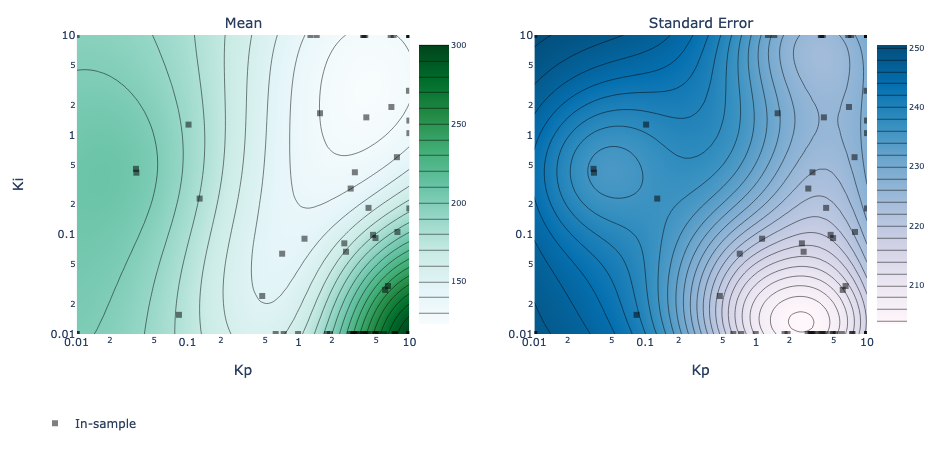

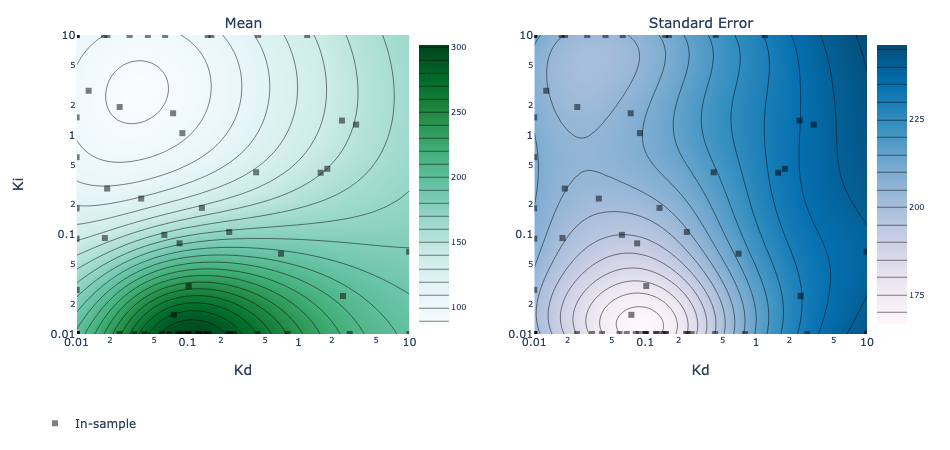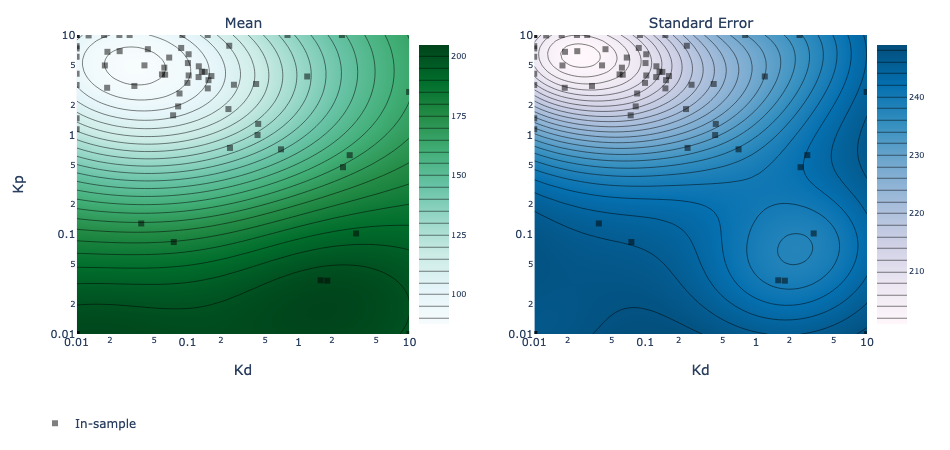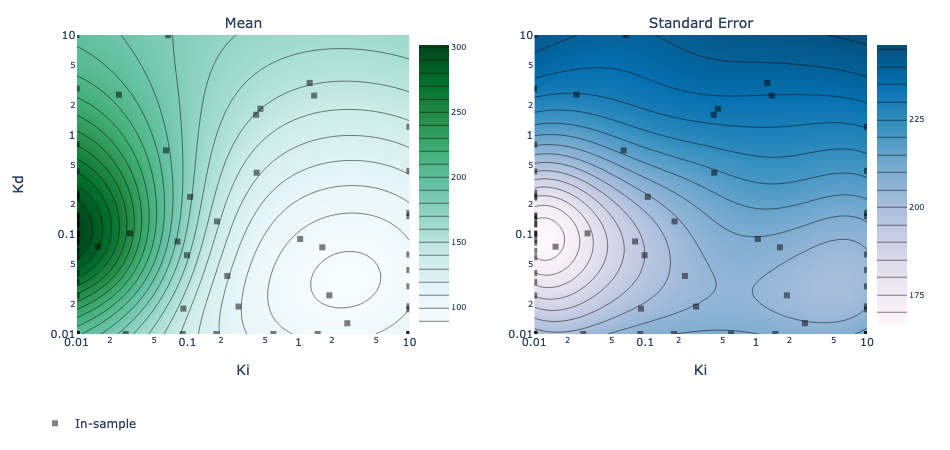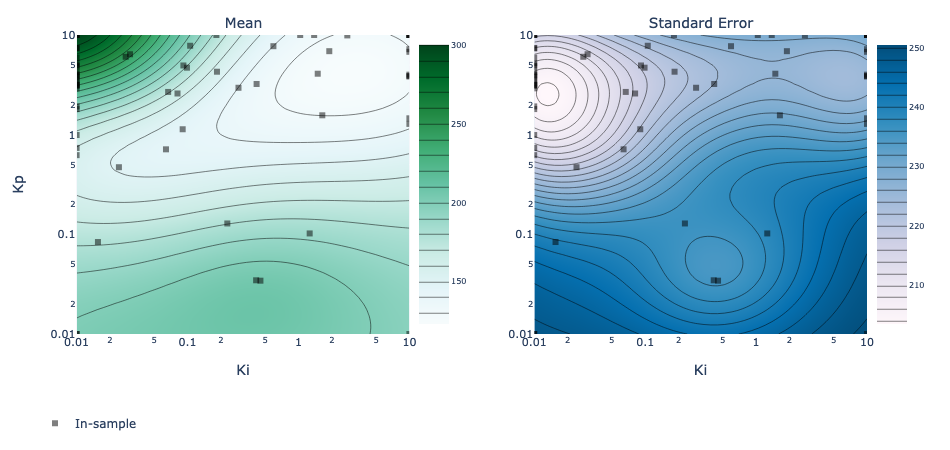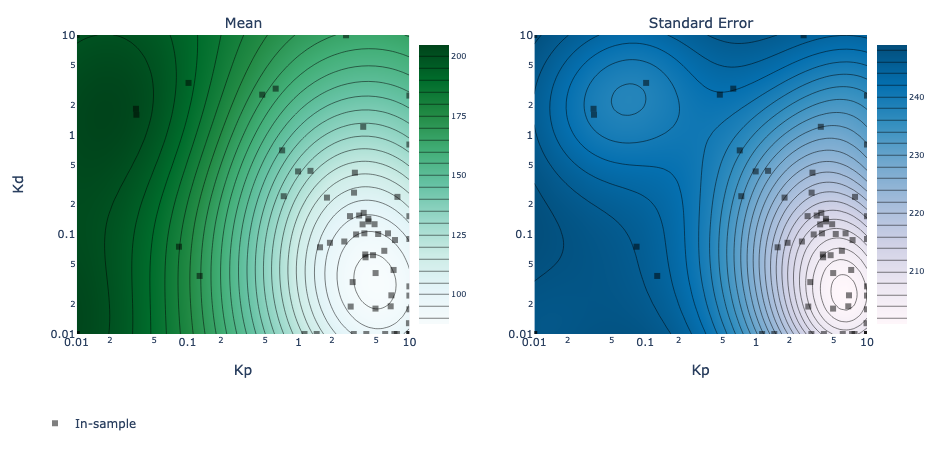

#### -- Best Trial

In [ ]:
import numpy as np
vals = ax.experiment.fetch_data().df['mean'].values
idx = np.argsort(vals)

print("Best trial, Val_score")
print('   ',idx[0],"     ", vals[idx[0]])

Best trial:  58

Val_score:   1.541712841

#### -- Optimized tuning Parameters

In [ ]:
import json
with open('PID_0.json', 'r') as f:
    data = json.load(f)
print(data['experiment']['trials'][str(idx[0])]['generator_run']['arms'])

[{'__type': 'Arm', 'parameters': {'Kp': 5.9384868942092455, 'Ki': 0.01, 'Kd': 0.06833812102228044}, 'name': '58_0'}]

#### -- Original Process Parameters

SCN
{'SAIE': 4.170619886453272, 'DC': 0.3592875658013883, 'Pu': 0.5305305305305306, 'Ku': 0.1342097257974246}


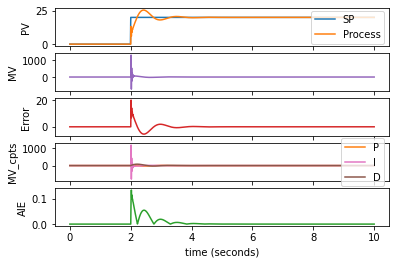

In [5]:
Run_Sim()

#### -- Tuned Process Parameters

SCN
{'SAIE': 3.3166915499349927, 'DC': 0.653521630781188, 'Pu': 0.15295295295295294, 'Ku': 0.14767030972599782}


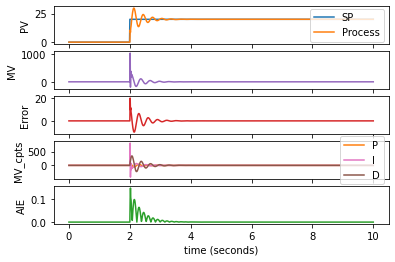

In [4]:
t_change = 2.
sim = Simulation(kp=5.9385, ki=0.01, kd=0.068338, MV0=0., PV0=0., t_change=t_change, step_to=20.)
metrics = sim.cycle()
print(metrics)
    
sim.Graph()

It should be noted that the simulation results here allign with other simulation results given by Matlab, often providing higher resolution curves than seen in the MatLab simulation. It is unclear at this time what could be done to improve the resolution of the MatLab simulations.

# Conclusions

### - Conclusions

From the Results shown here, optimization methodologies such as this are a prommising avenue for tuning PID parameters. It is important to note that there are significant areas where improvement needs to be made to make this a viable software package for use in industrial applications. 

### - Future Investigations

***Metrics***

In the evaluation of this optimization, it was clear that SAIE, the metric used to drive this optimization, was far from perfect for this application. This is clear when seeing the untuned and tuned response of this process. In the case of the untuned response, which has a higher (worse) SAIE, the process exhibits far less oscillatory behavior than seen in the tuned response. Oscillatory behavior is know to cause a myriad of concerns in industrial applications. Some of the most notable of which are: increased wear on valves, poor product yeild/selectivity, etc. 

Multiple course of action can be taken to mitigate these effects. Primarily, a multi-objective optimizer would be beneficial as this would allow for optimizations where the user could specify the level of allowable oscillatory behavior. Another course of action which would have a similar effect would be to normalize the SAIE metric and add a similarly normalized metric which encodes the oscillatory behavior of the system. These two metrics would then be combined into a single metric which could be optimized using the methodology described here.

***Process Parameters***

Further investigations should also be done to determine the effect that different process parameters have on this optimization. Given this optimization was done for a single first order system, it will be necessary to introduce processes with different parameters to determine if this route of optimization is generalizable to all processes of this order. Furthermore, this should be expanded to implementing FOPDT and Second order models. Evaluation of each of these models at varrying process parameters would better determine if the goal of having a model determine controller parameters is realizable using this methodology. 

***Using Ground Truth Data***

The results of this project have shown that given a simulated process, optimization can be performed to determine the best tuning parameters for a system. It would be very valuable to use ground-truth data to explore this topic further as this data presents a new set of challenges to explore. The main challenge being the limited amount of insight which can be gathered by a single system. 

### - Outlook

As applications of novel optimization strategies are explored further, time-saving solutions such as these will become more prevalent. PID tuning will continue to be at the heart of industrial controls, time saving and accuracy improvements will drive tuning to be performed algorithmically rather than manually. The results of this exploration prove that, under ideal conditions, optimization of these parameters are possible using optimization algorithms.   